In [206]:
#mask = X_raw["Gender"] == 0
#X_raw[~mask] stampo tutti quelli che hanno 1, senza ~ stampo tutti quelli con 0


#df.groupby(['attribute']).mean()
#pip install pysurvival
#%pip install pyodbc-4.0.32-cp310-cp310-win_amd64.whl

In [222]:
import sys
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
#import scikitplot as skplt
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from mrmr import mrmr_classif #feature selection
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS # feature selection



# packages for Survival analyis
from xgboost import XGBRegressor
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc, concordance_index_ipcw, integrated_brier_score
from sksurv.ensemble import RandomSurvivalForest, ExtraSurvivalTrees
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.svm import  HingeLossSurvivalSVM
from sksurv.kernels import clinical_kernel
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.nonparametric import kaplan_meier_estimator



## -----------------------------------------<br><br>Import data

In [23]:
df = pd.read_csv('RW_DATA_CUT-OFF_17.06.2021.csv')
data = df[['IT/CTIT', 'SurgeryY/N','AgeAtIO','Gender', 'SquamousNonSquamous', 'stadioAllaDiagnosi', 'fumoAllaDiagnosi','PDL1/1/149/50', 'LineaDiTerapiaICI', 'StageBasaleIO',  'BMIIoBasal', 'PS Baseline IO', 'TumorStage_IO', 'NodeStage_IO', 'MLiverBasale', 'RTPreIT', 'LeukocytesIOBasal', 'NeutrophylsiAlBasale', 'MonocytesalBasale','LymphocytesAlBasale','NLR','LDHAlBasale', 'MBoneBasale','MPleuraBasale', 'MLinfonodiBasale', 'MSurreneBasale', 'MBrainBasale','StatusOS','OSGeneraleMesi']]   #'PFSmesi','StatusPD'
# tolgo già packYears e Metastasis stage IO (una per troppi missing e l'altra per la correlazione)
# prendo OSmesiGenerale e PFSmesi (+ corrispondente evento)

# variabile evento deve essere al primo posto (ordine deve essere con prima StatusOS) per applicare

data

,IT/CTIT,SurgeryY/N,AgeAtIO,Gender,SquamousNonSquamous,stadioAllaDiagnosi,fumoAllaDiagnosi,PDL1/1/149/50,LineaDiTerapiaICI,StageBasaleIO,...,LymphocytesAlBasale,NLR,LDHAlBasale,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale,StatusOS,OSGeneraleMesi
0,2,0,81.333333,0,1,4,3,2.0,1,2,...,1400.0,3.357143,324.0,0,0,1,1,0,0,18.900000
1,1,1,73.166667,0,1,3,2,2.0,3,2,...,1100.0,4.272727,299.0,1,1,0,0,0,1,18.700000
2,1,0,78.666667,1,1,4,2,3.0,3,1,...,1600.0,2.687500,267.0,0,0,0,0,0,1,96.000000
3,1,0,44.333333,1,1,4,0,3.0,1,1,...,1300.0,10.615385,588.0,0,1,0,0,0,1,13.833333
4,1,0,61.583333,0,2,3,2,3.0,2,1,...,1400.0,1.571429,356.0,0,0,0,0,0,0,41.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1,0,63.166667,0,1,4,1,3.0,1,1,...,1900.0,2.526316,NaN,1,0,0,0,0,0,48.366667
476,2,0,69.166667,1,1,4,1,NaN,1,2,...,1200.0,4.333333,649.0,1,0,1,0,1,1,7.233333
477,1,0,74.250000,1,1,4,2,3.0,2,1,...,900.0,4.888889,398.0,0,1,0,0,0,1,10.866667
478,1,0,66.833333,0,1,4,2,3.0,1,1,...,2300.0,3.173913,325.0,1,0,0,0,0,1,6.700000


In [24]:
print(data.isna().sum())

IT/CTIT                   0
SurgeryY/N                0
AgeAtIO                   0
Gender                    0
SquamousNonSquamous       0
stadioAllaDiagnosi        0
fumoAllaDiagnosi          0
PDL1/1/149/50           116
LineaDiTerapiaICI         0
StageBasaleIO             0
BMIIoBasal               51
PS Baseline IO            0
TumorStage_IO             0
NodeStage_IO              0
MLiverBasale              0
RTPreIT                   0
LeukocytesIOBasal        26
NeutrophylsiAlBasale     25
MonocytesalBasale        29
LymphocytesAlBasale      29
NLR                      29
LDHAlBasale              88
MBoneBasale               0
MPleuraBasale             0
MLinfonodiBasale          0
MSurreneBasale            0
MBrainBasale              0
StatusOS                  0
OSGeneraleMesi            3
dtype: int64


In [25]:
# there are 3 missing values of OSGenerale, I delete the corresponding records
data=data.dropna(subset=['OSGeneraleMesi'])
X_raw=data.iloc[:,:-2]
y_raw=data.iloc[:,-2:]
X_raw

,IT/CTIT,SurgeryY/N,AgeAtIO,Gender,SquamousNonSquamous,stadioAllaDiagnosi,fumoAllaDiagnosi,PDL1/1/149/50,LineaDiTerapiaICI,StageBasaleIO,...,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,NLR,LDHAlBasale,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale
0,2,0,81.333333,0,1,4,3,2.0,1,2,...,4700.0,400.0,1400.0,3.357143,324.0,0,0,1,1,0
1,1,1,73.166667,0,1,3,2,2.0,3,2,...,4700.0,400.0,1100.0,4.272727,299.0,1,1,0,0,0
2,1,0,78.666667,1,1,4,2,3.0,3,1,...,4300.0,400.0,1600.0,2.687500,267.0,0,0,0,0,0
3,1,0,44.333333,1,1,4,0,3.0,1,1,...,13800.0,1200.0,1300.0,10.615385,588.0,0,1,0,0,0
4,1,0,61.583333,0,2,3,2,3.0,2,1,...,2200.0,200.0,1400.0,1.571429,356.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1,0,63.166667,0,1,4,1,3.0,1,1,...,4800.0,300.0,1900.0,2.526316,NaN,1,0,0,0,0
476,2,0,69.166667,1,1,4,1,NaN,1,2,...,5200.0,500.0,1200.0,4.333333,649.0,1,0,1,0,1
477,1,0,74.250000,1,1,4,2,3.0,2,1,...,4400.0,600.0,900.0,4.888889,398.0,0,1,0,0,0
478,1,0,66.833333,0,1,4,2,3.0,1,1,...,7300.0,1100.0,2300.0,3.173913,325.0,1,0,0,0,0


In [26]:
y_raw

,StatusOS,OSGeneraleMesi
0,0,18.900000
1,1,18.700000
2,1,96.000000
3,1,13.833333
4,0,41.733333
...,...,...
475,0,48.366667
476,1,7.233333
477,1,10.866667
478,1,6.700000


## ------------------------------------<br><br> Splitting & imputation

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, random_state=84, test_size = 0.1)
X_train

,IT/CTIT,SurgeryY/N,AgeAtIO,Gender,SquamousNonSquamous,stadioAllaDiagnosi,fumoAllaDiagnosi,PDL1/1/149/50,LineaDiTerapiaICI,StageBasaleIO,...,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,NLR,LDHAlBasale,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale
213,1,0,54.250000,1,2,4,1,NaN,2,1,...,2800.0,400.0,1600.0,1.750000,338.0,0,0,0,0,1
231,1,1,76.083333,1,1,2,1,3.0,2,2,...,5500.0,520.0,1100.0,5.000000,494.0,0,0,0,1,0
153,1,0,60.083333,0,1,4,2,3.0,3,2,...,2700.0,400.0,600.0,4.500000,401.0,0,1,0,0,0
167,1,0,61.500000,1,1,3,2,2.0,2,1,...,2200.0,300.0,1100.0,2.000000,381.0,0,0,0,0,0
282,1,0,62.000000,0,1,4,2,2.0,2,1,...,5300.0,400.0,1200.0,4.416667,298.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,2,0,77.666667,1,1,4,2,1.0,1,2,...,4700.0,300.0,600.0,7.833333,255.0,1,0,0,1,0
314,2,0,57.000000,0,1,3,1,1.0,1,0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
347,1,0,73.000000,1,2,4,2,2.0,1,1,...,10200.0,600.0,1500.0,6.800000,302.0,0,1,0,1,0
243,1,1,60.916667,1,2,3,2,2.0,1,2,...,4500.0,300.0,600.0,7.500000,304.0,1,1,0,1,0


In [28]:
# IMPUTATION

# define imputer
imputer = IterativeImputer()
# fit on the dataset
imputer.fit(X_train)
# transform the dataset
X1 = imputer.transform(X_train)
X2 = imputer.transform(X_test)
X_train = pd.DataFrame(X1, columns=X_train.columns)
X_test = pd.DataFrame(X2, columns=X_train.columns)

X_train['PDL1/1/149/50']=round(X_train['PDL1/1/149/50']).astype('int64')
X_test['PDL1/1/149/50']=round(X_test['PDL1/1/149/50']).astype('int64')
X_train
# This Multivariate approach assigns imputed values by solving a linear regression problem performed on other features. 
# Each feature containing missing values is, in turn, considered the target of the regression model. The
# imputation algorithm is fitted on the training set and then applied to both training and test dataset

,IT/CTIT,SurgeryY/N,AgeAtIO,Gender,SquamousNonSquamous,stadioAllaDiagnosi,fumoAllaDiagnosi,PDL1/1/149/50,LineaDiTerapiaICI,StageBasaleIO,...,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,NLR,LDHAlBasale,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale
0,1.0,0.0,54.250000,1.0,2.0,4.0,1.0,2,2.0,1.0,...,2800.000000,400.000000,1600.000000,1.750000,338.000000,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,76.083333,1.0,1.0,2.0,1.0,3,2.0,2.0,...,5500.000000,520.000000,1100.000000,5.000000,494.000000,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,60.083333,0.0,1.0,4.0,2.0,3,3.0,2.0,...,2700.000000,400.000000,600.000000,4.500000,401.000000,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,61.500000,1.0,1.0,3.0,2.0,2,2.0,1.0,...,2200.000000,300.000000,1100.000000,2.000000,381.000000,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,62.000000,0.0,1.0,4.0,2.0,2,2.0,1.0,...,5300.000000,400.000000,1200.000000,4.416667,298.000000,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,2.0,0.0,77.666667,1.0,1.0,4.0,2.0,1,1.0,2.0,...,4700.000000,300.000000,600.000000,7.833333,255.000000,1.0,0.0,0.0,1.0,0.0
425,2.0,0.0,57.000000,0.0,1.0,3.0,1.0,1,1.0,0.0,...,6120.395533,519.076655,1429.375056,5.519192,412.044433,0.0,0.0,0.0,0.0,0.0
426,1.0,0.0,73.000000,1.0,2.0,4.0,2.0,2,1.0,1.0,...,10200.000000,600.000000,1500.000000,6.800000,302.000000,0.0,1.0,0.0,1.0,0.0
427,1.0,1.0,60.916667,1.0,2.0,3.0,2.0,2,1.0,2.0,...,4500.000000,300.000000,600.000000,7.500000,304.000000,1.0,1.0,0.0,1.0,0.0


## --------------------------------<br><br>Data exploration

In [29]:
X_train.dtypes

IT/CTIT                 float64
SurgeryY/N              float64
AgeAtIO                 float64
Gender                  float64
SquamousNonSquamous     float64
stadioAllaDiagnosi      float64
fumoAllaDiagnosi        float64
PDL1/1/149/50             int64
LineaDiTerapiaICI       float64
StageBasaleIO           float64
BMIIoBasal              float64
PS Baseline IO          float64
TumorStage_IO           float64
NodeStage_IO            float64
MLiverBasale            float64
RTPreIT                 float64
LeukocytesIOBasal       float64
NeutrophylsiAlBasale    float64
MonocytesalBasale       float64
LymphocytesAlBasale     float64
NLR                     float64
LDHAlBasale             float64
MBoneBasale             float64
MPleuraBasale           float64
MLinfonodiBasale        float64
MSurreneBasale          float64
MBrainBasale            float64
dtype: object

In [30]:
categorical_features_indices = np.where(X_raw.dtypes == 'int64')[0]
#result = np.where(h == 'PDL1/1/149/50')
X_train_categorical=X_train.iloc[:,categorical_features_indices].astype(int)
X_train_categorical['PDL1/1/149/50']=X_train['PDL1/1/149/50']
X_test_categorical=X_test.iloc[:,categorical_features_indices].astype(int)
X_test_categorical['PDL1/1/149/50']=X_test['PDL1/1/149/50']
X_train_categorical

,IT/CTIT,SurgeryY/N,Gender,SquamousNonSquamous,stadioAllaDiagnosi,fumoAllaDiagnosi,LineaDiTerapiaICI,StageBasaleIO,PS Baseline IO,TumorStage_IO,NodeStage_IO,MLiverBasale,RTPreIT,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale,PDL1/1/149/50
0,1,0,1,2,4,1,2,1,1,0,2,0,1,0,0,0,0,1,2
1,1,1,1,1,2,1,2,2,1,3,2,0,1,0,0,0,1,0,3
2,1,0,0,1,4,2,3,2,0,4,2,0,1,0,1,0,0,0,3
3,1,0,1,1,3,2,2,1,0,4,1,0,0,0,0,0,0,0,2
4,1,0,0,1,4,2,2,1,1,3,0,0,1,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,2,0,1,1,4,2,1,2,1,3,2,0,1,1,0,0,1,0,1
425,2,0,0,1,3,1,1,0,1,4,2,0,0,0,0,0,0,0,1
426,1,0,1,2,4,2,1,1,1,4,2,0,0,0,1,0,1,0,2
427,1,1,1,2,3,2,1,2,1,4,3,0,1,1,1,0,1,0,2


In [31]:
numerical_features_indices = np.where(X_raw.dtypes == 'float64')[0]
X_train_numerical=X_train.iloc[:,numerical_features_indices]
X_train_numerical=X_train_numerical.drop(['PDL1/1/149/50'],axis=1)
X_test_numerical=X_test.iloc[:,numerical_features_indices]
X_test_numerical=X_test_numerical.drop(['PDL1/1/149/50'],axis=1)
X_train_numerical

,AgeAtIO,BMIIoBasal,LeukocytesIOBasal,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,NLR,LDHAlBasale
0,54.250000,31.699070,5300.000000,2800.000000,400.000000,1600.000000,1.750000,338.000000
1,76.083333,22.031726,7200.000000,5500.000000,520.000000,1100.000000,5.000000,494.000000
2,60.083333,22.206331,4310.000000,2700.000000,400.000000,600.000000,4.500000,401.000000
3,61.500000,23.030045,3950.000000,2200.000000,300.000000,1100.000000,2.000000,381.000000
4,62.000000,27.915519,13100.000000,5300.000000,400.000000,1200.000000,4.416667,298.000000
...,...,...,...,...,...,...,...,...
424,77.666667,19.600000,5780.000000,4700.000000,300.000000,600.000000,7.833333,255.000000
425,57.000000,26.989619,8983.018895,6120.395533,519.076655,1429.375056,5.519192,412.044433
426,73.000000,22.800000,12700.000000,10200.000000,600.000000,1500.000000,6.800000,302.000000
427,60.916667,22.205990,5750.000000,4500.000000,300.000000,600.000000,7.500000,304.000000


array([[<AxesSubplot:title={'center':'AgeAtIO'}>,
        <AxesSubplot:title={'center':'BMIIoBasal'}>,
        <AxesSubplot:title={'center':'LeukocytesIOBasal'}>,
        <AxesSubplot:title={'center':'NeutrophylsiAlBasale'}>],
       [<AxesSubplot:title={'center':'MonocytesalBasale'}>,
        <AxesSubplot:title={'center':'LymphocytesAlBasale'}>,
        <AxesSubplot:title={'center':'NLR'}>,
        <AxesSubplot:title={'center':'LDHAlBasale'}>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

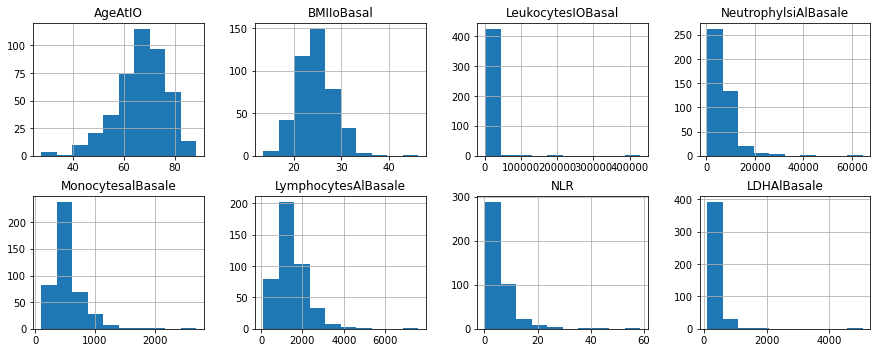

In [32]:
X=X_train_numerical


X.hist(layout=(4,4), figsize=(15,12))


# età è praticamente uguale, anche genere, idem squamoso, non squamoso, stadio alla diagnosi, BMI basale, M_surrene, M_brain
# outliers in LDHA e Leucociti

#leucociti, NLR e LDHA potrebbero avere outlier o essere power lwa distribution

In [33]:
neg_value=np.where(X['LeukocytesIOBasal']>0)[0]
X=X.iloc[neg_value,:]
print(X.shape)

(429, 8)


array([[<AxesSubplot:title={'center':'logLeuko'}>,
        <AxesSubplot:title={'center':'LeukocytesIOBasal'}>,
        <AxesSubplot:title={'center':'logNLR'}>,
        <AxesSubplot:title={'center':'NLR'}>],
       [<AxesSubplot:title={'center':'logLDHA'}>,
        <AxesSubplot:title={'center':'LDHAlBasale'}>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

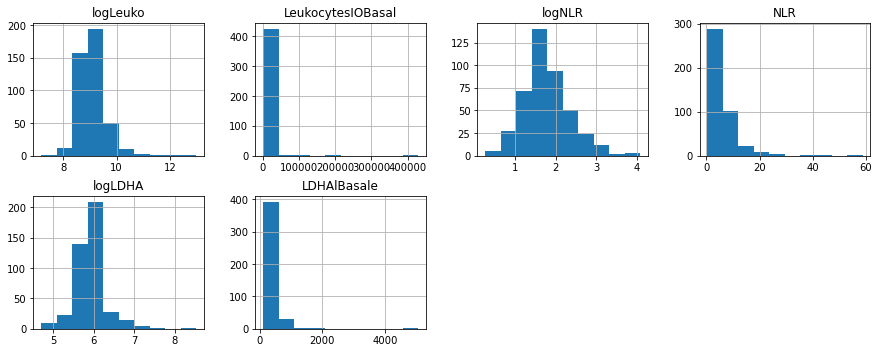

In [34]:
import math
X['logLeuko']=X['LeukocytesIOBasal'].apply(lambda x: math.log(x+1))
X['logNLR']=X['NLR'].apply(lambda x: math.log(x+1))
X['logLDHA']=X['LDHAlBasale'].apply(lambda x: math.log(x+1))

X[['logLeuko','LeukocytesIOBasal','logNLR','NLR','logLDHA','LDHAlBasale']].hist(layout=(4,4), figsize=(15,12))


# posso tenere logNLR e logLDHA
# di leukocytes posso rimuovere outliers (o anche mantenere log)

In [35]:
X=X.drop(['LDHAlBasale','NLR','LeukocytesIOBasal'],axis=1)
X

,AgeAtIO,BMIIoBasal,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,logLeuko,logNLR,logLDHA
0,54.250000,31.699070,2800.000000,400.000000,1600.000000,8.575651,1.011601,5.826000
1,76.083333,22.031726,5500.000000,520.000000,1100.000000,8.881975,1.791759,6.204558
2,60.083333,22.206331,2700.000000,400.000000,600.000000,8.368925,1.704748,5.996452
3,61.500000,23.030045,2200.000000,300.000000,1100.000000,8.281724,1.098612,5.945421
4,62.000000,27.915519,5300.000000,400.000000,1200.000000,9.480444,1.689481,5.700444
...,...,...,...,...,...,...,...,...
424,77.666667,19.600000,4700.000000,300.000000,600.000000,8.662332,2.178532,5.545177
425,57.000000,26.989619,6120.395533,519.076655,1429.375056,9.103203,1.874750,6.023555
426,73.000000,22.800000,10200.000000,600.000000,1500.000000,9.449436,2.054124,5.713733
427,60.916667,22.205990,4500.000000,300.000000,600.000000,8.657129,2.140066,5.720312


In [36]:
h=np.array(X.index)
X_train_numerical=X
X_train_categorical=X_train_categorical.iloc[h,:]
y_train=y_train.iloc[h]

X_test_numerical['logLeuko']=X_test_numerical['LeukocytesIOBasal'].apply(lambda x: math.log(x+1))
X_test_numerical['logNLR']=X_test_numerical['NLR'].apply(lambda x: math.log(x+1))
X_test_numerical['logLDHA']=X_test_numerical['LDHAlBasale'].apply(lambda x: math.log(x+1))
X_test_numerical=X_test_numerical.drop(['NLR','LDHAlBasale','LeukocytesIOBasal'],axis=1)
X_test_numerical.columns

Index(['AgeAtIO', 'BMIIoBasal', 'NeutrophylsiAlBasale', 'MonocytesalBasale',
       'LymphocytesAlBasale', 'logLeuko', 'logNLR', 'logLDHA'],
      dtype='object')

## --------------------------<br><br> NORMALIZATION

In [37]:
scaler = StandardScaler()
scaler.fit(X_train_numerical)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_numerical))  # scaling viene fatto sul training set
X_train_scaled.columns=X_train_numerical.columns
X_train_categorical.index=X_train_scaled.index

X_test_scaled = pd.DataFrame(scaler.transform(X_test_numerical))
X_test_scaled.columns=X_test_numerical.columns
X_test_categorical.index=X_test_scaled.index

In [38]:
X_train=pd.concat([X_train_scaled,X_train_categorical],axis=1)
X_test=pd.concat([X_test_scaled,X_test_categorical],axis=1)

y_train.index=X_train.index
y_test.index=X_test.index

X_train

,AgeAtIO,BMIIoBasal,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,logLeuko,logNLR,logLDHA,IT/CTIT,SurgeryY/N,...,TumorStage_IO,NodeStage_IO,MLiverBasale,RTPreIT,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale,PDL1/1/149/50
0,-1.246012,1.856246,-0.791239,-0.547583,0.192490,-0.965864,-1.353323,-0.268396,1,0,...,0,2,0,1,0,0,0,0,1,2
1,0.936869,-0.648786,-0.309190,-0.102402,-0.475270,-0.384947,0.011636,0.693996,1,1,...,3,2,0,1,0,0,0,1,0,3
2,-0.662800,-0.603542,-0.809092,-0.547583,-1.143030,-1.357900,-0.140598,0.164937,1,0,...,4,2,0,1,0,1,0,0,0,3
3,-0.521162,-0.390098,-0.898361,-0.918566,-0.475270,-1.523270,-1.201088,0.035202,1,0,...,4,1,0,0,0,0,0,0,0,2
4,-0.471173,0.875840,-0.344897,-0.547583,-0.341718,0.749996,-0.167310,-0.587594,1,0,...,3,0,0,1,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,1.095169,-1.278902,-0.452019,-0.918566,-1.143030,-0.801481,0.688330,-0.982321,2,0,...,3,2,0,1,1,0,0,1,0,1
425,-0.971069,0.635919,-0.198427,-0.105827,-0.035383,0.034591,0.156836,0.233840,2,0,...,4,2,0,0,0,0,0,0,0,1
426,0.628599,-0.449708,0.529932,0.194385,0.058938,0.691192,0.470666,-0.553809,1,0,...,4,2,0,0,0,1,0,1,0,2
427,-0.579483,-0.603630,-0.487726,-0.918566,-1.143030,-0.811347,0.621030,-0.537084,1,1,...,4,3,0,1,1,1,0,1,0,2


In [39]:
# values of the event must be boolean
y_train['StatusOS']=y_train['StatusOS'].astype(bool)
y_test['StatusOS']=y_test['StatusOS'].astype(bool)
# targets must be an array (not a dataframe)
y_tr=y_train.to_records(index=False)
y_t=y_test.to_records(index=False)

y_t

rec.array([(False,  60.93333333), (False,   5.6       ),
           ( True,  14.06666667), ( True,  52.63333333),
           ( True,   2.5       ), ( True,   1.86666667),
           ( True,  37.73333333), ( True,   8.1       ),
           ( True,  12.6       ), ( True,  37.2       ),
           ( True,  22.06666667), ( True,  22.96666667),
           (False,  50.96666667), (False,  15.16666667),
           ( True,   6.86666667), ( True,   8.26666667),
           (False,  41.63333333), ( True,  27.8       ),
           (False,  80.96666667), ( True,  10.86666667),
           ( True,  45.4       ), (False,   6.53333333),
           (False,  54.6       ), ( True,  85.        ),
           ( True,  22.06666667), (False,  54.        ),
           ( True,  21.4       ), ( True,  27.        ),
           ( True,   3.1       ), ( True,   3.1       ),
           ( True,  10.46666667), ( True, 125.13333333),
           ( True,  13.83333333), ( True,   4.96666667),
           (False,  24.6       

## ------------------------------- <br><br>FEATURE SELECTION

### <br><br> Single feature

In [20]:
cox_best=CoxPHSurvivalAnalysis(n_iter=5)
rsf_best=RandomSurvivalForest(n_estimators=200,max_depth=5, min_samples_split=6, min_samples_leaf=7)
gb_best=GradientBoostingSurvivalAnalysis(n_estimators=200,
                                            learning_rate=0.1,
                                            min_samples_split=5,
                                            min_samples_leaf=15,
                                            max_depth=3,
                                            random_state=42)

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores_cox = np.empty(n_features)
    scores_rsf = np.empty(n_features)
    scores_gb = np.empty(n_features)
    
    for j in range(n_features):
        Xj = X.iloc[:, j:j+1]
        cox_best.fit(Xj, y)
        rsf_best.fit(Xj, y)
        gb_best.fit(Xj, y)
        scores_cox[j] = cox_best.score(Xj, y)
        scores_rsf[j] = rsf_best.score(Xj, y)
        scores_gb[j] = gb_best.score(Xj, y)
    return scores_cox, scores_rsf, scores_gb


scores_cox, scores_rsf, scores_gb = fit_and_score_features(X_train, y_tr)

feats_cox=pd.Series(scores_cox, index=X_train.columns).sort_values(ascending=False)
feats_rsf=pd.Series(scores_rsf, index=X_train.columns).sort_values(ascending=False)
feats_gb=pd.Series(scores_gb, index=X_train.columns).sort_values(ascending=False)

# indice della serie è nome della variabile!!
feats_rsf

NeutrophylsiAlBasale    0.705450
logLeuko                0.704688
logNLR                  0.686261
BMIIoBasal              0.656323
logLDHA                 0.653453
AgeAtIO                 0.636612
MonocytesalBasale       0.632472
PS Baseline IO          0.622465
LymphocytesAlBasale     0.614566
stadioAllaDiagnosi      0.598346
SurgeryY/N              0.593987
StageBasaleIO           0.567357
MLiverBasale            0.546715
LineaDiTerapiaICI       0.545340
MBoneBasale             0.542695
MSurreneBasale          0.542392
TumorStage_IO           0.542060
fumoAllaDiagnosi        0.535967
Gender                  0.535262
NodeStage_IO            0.533421
SquamousNonSquamous     0.526425
RTPreIT                 0.519302
MBrainBasale            0.517441
MLinfonodiBasale        0.505000
MPleuraBasale           0.504514
IT/CTIT                 0.502842
PDL1/1/149/50           0.491918
dtype: float64

In [21]:
cind_cox_feat=[]
cind_rsf_feat=[]
cind_gb_feat=[]

for i in range(feats_cox.shape[0]):   
# se voglio usare due variabili contemporaneamente nel for uso "zip(feat.shape,feats)""
# se voglio scorrere un array/altro indicizzato uso "enumerate(feats)"
    X_tr_cox=X_train.loc[:,feats_cox.index[0:i+1]]
    X_tr_rsf=X_train.loc[:,feats_rsf.index[0:i+1]]
    X_tr_gb=X_train.loc[:,feats_gb.index[0:i+1]]
    
    cox_best.fit(X_tr_cox,y_tr)
    rsf_best.fit(X_tr_rsf,y_tr)
    gb_best.fit(X_tr_gb,y_tr)
    
    cind_cox_feat.append(cox_best.score(X_test.loc[:,feats_cox.index[0:i+1]],y_t))
    cind_rsf_feat.append(rsf_best.score(X_test.loc[:,feats_rsf.index[0:i+1]],y_t))
    cind_gb_feat.append(gb_best.score(X_test.loc[:,feats_gb.index[0:i+1]],y_t))
    
print("Best number of features for CPH: {b}\nc-ind={m}\n--------------------".format(b=cind_cox_feat.index(max(cind_cox_feat))+1,m=max(cind_cox_feat)))
print("Best number of features for RSF: {b}\nc-ind={m}\n--------------------".format(b=cind_rsf_feat.index(max(cind_rsf_feat))+1,m=max(cind_rsf_feat)))
print("Best number of features for GB: {b}\nc-ind={m}".format(b=cind_gb_feat.index(max(cind_gb_feat))+1,m=max(cind_gb_feat)))

Best number of features for CPH: 27
c-ind=0.7777777777777778
--------------------
Best number of features for RSF: 23
c-ind=0.7481481481481481
--------------------
Best number of features for GB: 27
c-ind=0.7343915343915344


### <br><br>LASSO Elastic Net

In [40]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

In [41]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(X_train, y_tr)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

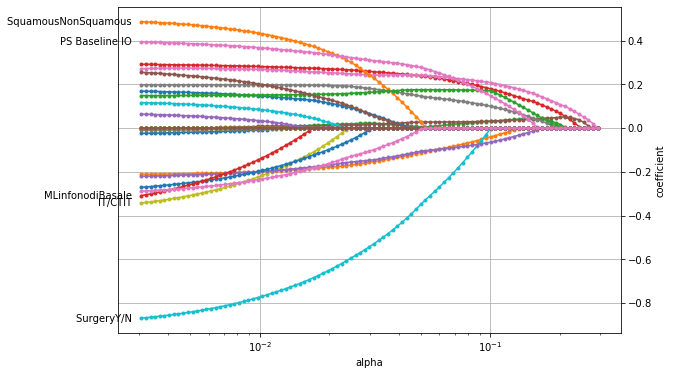

In [42]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=X_train.columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

In [43]:
estimated_alphas=cox_elastic_net.alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)

gcv = GridSearchCV(
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01),
    param_grid={"alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,# valore da assegnare allo score se durante fitting avviene un errore
    n_jobs=1)

gcv=gcv.fit(X_train,y_tr)


cv_results = pd.DataFrame(gcv.cv_results_)

In [44]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009308,0.003679,0.010295,0.006099,[0.29220911279162265],{'alphas': [0.29220911279162265]},0.500000,0.500000,0.580772,0.661988,0.612661,0.571084,0.063548,99
1,0.006248,0.007652,0.006251,0.007656,[0.27892775763776717],{'alphas': [0.27892775763776717]},0.656699,0.500000,0.577015,0.660850,0.626422,0.604197,0.060093,98
2,0.003125,0.006249,0.000000,0.000000,[0.26625006057327677],{'alphas': [0.26625006057327677]},0.656699,0.661378,0.578552,0.660470,0.637064,0.638833,0.031409,97
3,0.003122,0.006245,0.003122,0.006245,[0.2541485844063412],{'alphas': [0.2541485844063412]},0.671901,0.661378,0.581967,0.654021,0.641468,0.642147,0.031680,96
4,0.006249,0.007653,0.003138,0.006275,[0.24259713900786287],{'alphas': [0.24259713900786287]},0.676579,0.661378,0.584358,0.653642,0.640367,0.643265,0.031699,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.006254,0.007659,0.003124,0.006248,[0.003687260802707257],{'alphas': [0.003687260802707257]},0.732376,0.792643,0.707650,0.736343,0.731009,0.740004,0.028179,39
95,0.003132,0.006264,0.003121,0.006242,[0.0035196691085338876],{'alphas': [0.0035196691085338876]},0.732041,0.792643,0.707650,0.735584,0.731743,0.739932,0.028174,42
96,0.003125,0.006250,0.006250,0.007654,[0.0033596947155113558],{'alphas': [0.0033596947155113558]},0.731039,0.792643,0.706967,0.735584,0.731743,0.739595,0.028389,50
97,0.006248,0.007653,0.003127,0.006254,[0.0032069914055462842],{'alphas': [0.0032069914055462842]},0.731373,0.792643,0.707309,0.735205,0.732110,0.739728,0.028282,48


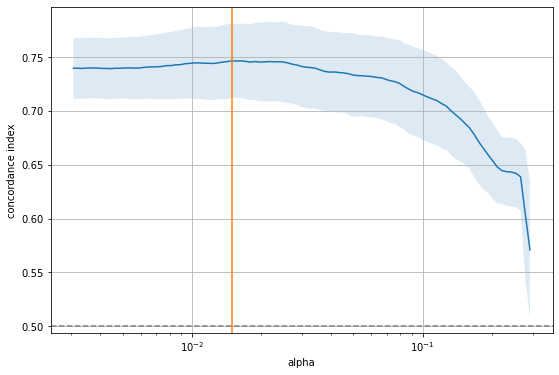

In [45]:
alphas = cv_results.param_alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 19


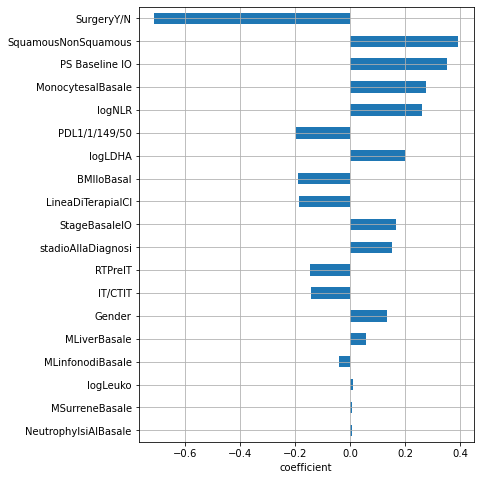

In [46]:
best_model = gcv.best_estimator_
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=X_train.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [47]:
coefs_best=best_coefs.index[np.where(best_coefs['coefficient']!=0)[0]]
coefs_best


Index(['BMIIoBasal', 'NeutrophylsiAlBasale', 'MonocytesalBasale', 'logLeuko',
       'logNLR', 'logLDHA', 'IT/CTIT', 'SurgeryY/N', 'Gender',
       'SquamousNonSquamous', 'stadioAllaDiagnosi', 'LineaDiTerapiaICI',
       'StageBasaleIO', 'PS Baseline IO', 'MLiverBasale', 'RTPreIT',
       'MLinfonodiBasale', 'MSurreneBasale', 'PDL1/1/149/50'],
      dtype='object')

In [48]:
X_tr=X_train.loc[:,coefs_best]
X_t=X_test.loc[:,coefs_best]

## ---------------------------------<br><br> SURVIVAL ANALYSIS

In [165]:
# per fare valutazione della AUC dinamica devo andare a considerare tempi del test set (estremo superiore<t_max & inf>t_min)
times = np.linspace(min(y_t["OSGeneraleMesi"])+0.001,max(y_t["OSGeneraleMesi"])-0.001,30)

### <br><br> CPH model

In [103]:
cox=CoxPHSurvivalAnalysis()

In [104]:
param_grid = {'n_iter': [5,10,15,20,50,100]}
cv = KFold(n_splits=10, random_state=84, shuffle=True)
#cv=StratifiedKFold(10)
gcv = GridSearchCV(cox, param_grid, return_train_score=True, cv=cv)
gcv.fit(X_tr, y_tr)

#results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
#results.loc[:, ~results.columns.str.endswith("_time")]
#results.loc[:,['mean_test_score','params','rank_test_score']]

print("Best score: {f}".format(f=gcv.best_score_))
print("Parameters: {f}".format(f=gcv.best_params_))


# con logaritmo ho migliorato il c-index

Best score: 0.7582583622567854
Parameters: {'n_iter': 5}


In [164]:
cox=gcv.best_estimator_
ci_cox_train = concordance_index_censored(y_tr["StatusOS"], y_tr["OSGeneraleMesi"], cox.predict(X_tr))
ci_cox_test = concordance_index_censored(y_t["StatusOS"], y_t["OSGeneraleMesi"], cox.predict(X_t))

print("COX PROPORTIONAL HAZARDS\n----------------------")
print("C-index TRAIN: {f}".format(f=ci_cox_train[0]))
print("C-index TEST: {f}".format(f=ci_cox_test[0]))

# The concordance index is defined as the proportion of all comparable pairs in which the predictions and outcomes are 
# concordant.
# Two samples are comparable if (i) both of them experienced an event (at different times), or (ii) the one with a shorter 
# observed survival time experienced an event, in which case the event-free subject “outlived” the other. A pair is not 
# comparable if they experienced events at the same time.

# c[0]= c-index
# c[1]= number of concordant pairs (two samples are concordant, if the one with a higher estimated 
#                                   risk score has a shorter actual survival time)
# c[2]= number of discordant pairs
# c[3]= number of pairs having tied estimated risks (When predicted risks are identical for a pair, 0.5 rather than 1 is 
#                                                    added to the count of concordant pairs.)

survs_cox=cox.predict_survival_function(X_t)
preds_cox = np.asarray([[fn(t) for t in times] for fn in survs_cox])

bs_cox=integrated_brier_score(y_tr,y_t,preds_cox,times)
print("Brier Score CPH: ",bs_cox)


COX PROPORTIONAL HAZARDS
----------------------
C-index TRAIN: 0.7670456148269345
C-index TEST: 0.7841269841269841
Brier Score CPH:  0.10754714895992247


### <br><br> Random Survival Forest

In [210]:
rsf = RandomSurvivalForest()
param_grid = {'n_estimators': [200,400],
              'max_depth':[3,5],
              'min_samples_split':[6,8],
              'min_samples_leaf':[7,10]
             }

gcv1 = GridSearchCV(rsf, param_grid, return_train_score=True, cv=cv)
gcv1.fit(X_tr, y_tr)
print("Best score: {f}".format(f=gcv1.best_score_))
print("Parameters: {f}".format(f=gcv1.best_params_))

Best score: 0.7324234783964074
Parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 400}


In [213]:
rsf=gcv1.best_estimator_
ci_rsf_train = concordance_index_censored(y_tr["StatusOS"], y_tr["OSGeneraleMesi"], rsf.predict(X_tr))
# rsf.predict----> calcolo risk score
ci_rsf_test = concordance_index_censored(y_t["StatusOS"], y_t["OSGeneraleMesi"], rsf.predict(X_t))

print("RANDOM SURVIVAL FOREST\n----------------------")
print("C-index TRAIN: {c}".format(c=ci_rsf_train[0]))
print("C-index TEST: {c}".format(c=ci_rsf_test[0]))

survs_rsf=rsf.predict_survival_function(X_t)
preds_rsf = np.asarray([[fn(t) for t in times] for fn in survs_rsf])

bs_rsf=integrated_brier_score(y_tr,y_t,preds_rsf,times)
print("Brier Score RSF: ",bs_rsf)

RANDOM SURVIVAL FOREST
----------------------
C-index TRAIN: 0.7822928714491241
C-index TEST: 0.7470899470899471
Brier Score RSF:  0.12093710853972454


### <br><br> Gradient Boosting

In [53]:
# criterion='friedman_mse'---> the best criterion (di default)
# loss='coxph' ---> migliore e di default
gb = GradientBoostingSurvivalAnalysis()

param_grid={'n_estimators':[200,400,600],
           'learning_rate':[0.1,1,10],
           'min_samples_split':[5,7,9],
           'min_samples_leaf':[10,15],
           'max_depth':[3,4,6],
           'random_state':[42]}


gcv2 = GridSearchCV(gb, param_grid, return_train_score=True, cv=cv)
gcv2.fit(X_tr, y_tr)
print("Best score: {f}".format(f=gcv2.best_score_))
print("Parameters: {f}".format(f=gcv2.best_params_))

Best score: 0.7291580344660145
Parameters: {'learning_rate': 1, 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 600, 'random_state': 42}


In [54]:
gb=gcv2.best_estimator_
ci_gb_train = concordance_index_censored(y_tr["StatusOS"], y_tr["OSGeneraleMesi"], gb.predict(X_tr))
ci_gb_test = concordance_index_censored(y_t["StatusOS"], y_t["OSGeneraleMesi"], gb.predict(X_t))

print("GRADIENT BOOSTING\n----------------------")
print("C-index TRAIN: {f}".format(f=ci_gb_train[0]))
print("C-index TEST: {f}".format(f=ci_gb_test[0]))

survs_gb=gb.predict_survival_function(X_t)
preds_gb = np.asarray([[fn(t) for t in times] for fn in survs_gb])

bs_gb=integrated_brier_score(y_tr,y_t,preds_gb,times)
print("Brier Score GB: ",bs_gb)


GRADIENT BOOSTING
----------------------
C-index TRAIN: 0.9999153713786002
C-index TEST: 0.7502645502645503


### <br><br> FastKernelSurvival SVM

In [52]:
fks=FastKernelSurvivalSVM()
param_grid={"kernel":['linear','rbf','polinomial'], "alpha":[0.1,1,10],"gamma":[1,2], "degree":[2,3,4]}

gcv3 = GridSearchCV(fks, param_grid, return_train_score=True, cv=cv, verbose=1, n_jobs=-1)
gcv3.fit(X_tr, y_tr)
print("Best score: {f}".format(f=gcv3.best_score_))
print("Parameters: {f}".format(f=gcv3.best_params_))

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best score: 0.7674012267441496
Parameters: {'alpha': 0.1, 'degree': 4, 'gamma': 1, 'kernel': 'linear'}


In [53]:
fks=gcv3.best_estimator_
ci_fks_train = concordance_index_censored(y_tr["StatusOS"], y_tr["OSGeneraleMesi"], fks.predict(X_tr))
ci_fks_test = concordance_index_censored(y_t["StatusOS"], y_t["OSGeneraleMesi"], fks.predict(X_t))

print("FAST KERNEL SSVM\n----------------------")
print("C-index TRAIN: {f}".format(f=ci_fks_train[0]))
print("C-index TEST: {f}".format(f=ci_fks_test[0]))

# SSVM non ha predict survival function (GB, CPH e RSF invece sì)

FAST KERNEL SSVM
----------------------
C-index TRAIN: 0.778964145674067
C-index TEST: 0.7798941798941799


### <br><br> ExtraTree

In [249]:
et = ExtraSurvivalTrees()
param_grid = {'n_estimators': [200,400],
              'max_depth':[3,5],
              'min_samples_split':[6,8],
              'min_samples_leaf':[7,10]
             }

gcv4 = GridSearchCV(et, param_grid, return_train_score=True, cv=cv)
gcv4.fit(X_tr, y_tr)
print("Best score: {f}".format(f=gcv4.best_score_))
print("Parameters: {f}".format(f=gcv4.best_params_))

Best score: 0.742052686030531
Parameters: {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 400}


In [250]:
et=gcv4.best_estimator_
ci_et_train = concordance_index_censored(y_tr["StatusOS"], y_tr["OSGeneraleMesi"], et.predict(X_tr))
ci_et_test = concordance_index_censored(y_t["StatusOS"], y_t["OSGeneraleMesi"], et.predict(X_t))

print("EXTRA TREES\n----------------------")
print("C-index TRAIN: {f}".format(f=ci_et_train[0]))
print("C-index TEST: {f}".format(f=ci_et_test[0]))

survs_et=et.predict_survival_function(X_t)
preds_et = np.asarray([[fn(t) for t in times] for fn in survs_et])

bs_et=integrated_brier_score(y_tr,y_t,preds_et,times)
print("Brier Score ET: ",bs_et)

EXTRA TREES
----------------------
C-index TRAIN: 0.752574120567576
C-index TEST: 0.7492063492063492
Brier Score ET:  0.1250436918445346


## <br><br> Evaluating Survival Models

### Time dependent AUC

Average SSVM:  0.8762606271555421
Average CPH:  0.8796277693243102
Average RSF:  0.8515779488331
Average ETS:  0.8409452985068389


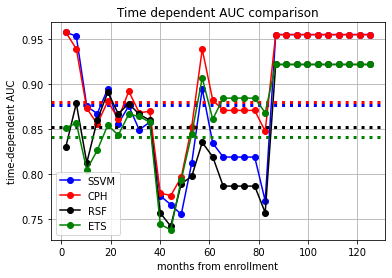

In [251]:
fks_risk_scores=fks.predict(X_t)
fks_auc, fks_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, fks_risk_scores, times
)

cox_risk_scores=cox.predict(X_t)
cox_auc, cox_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, cox_risk_scores, times
)

et_risk_scores=et.predict(X_t)
et_auc, et_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, et_risk_scores, times
)

rsf_risk_scores=rsf.predict(X_t)
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, rsf_risk_scores, times
)


plt.plot(times, fks_auc, "bo-",label="SSVM")
plt.axhline(fks_mean_auc, linestyle="dotted", color="b",linewidth=3)
plt.plot(times, cox_auc, "ro-",label="CPH")
plt.axhline(cox_mean_auc, linestyle="dotted", color="r",linewidth=3)
plt.plot(times, rsf_auc, "ko-",label="RSF")
plt.axhline(rsf_mean_auc, linestyle="dotted", color="k",linewidth=3)
plt.plot(times, et_auc, "go-",label="ETS")
plt.axhline(et_mean_auc, linestyle="dotted", color="g",linewidth=3)

plt.xlabel("months from enrollment")
plt.ylabel("time-dependent AUC")
plt.title("Time dependent AUC comparison")
plt.legend(loc="best")
plt.grid(True)

print("Average SSVM: ",fks_mean_auc)
print("Average CPH: ",cox_mean_auc)
print("Average RSF: ",rsf_mean_auc)
print("Average ETS: ",et_mean_auc)



### <br><br>  Estimation of Survival Functions

In [252]:
# KAPLAN MEIER ESTIMATION FOR SURVIVAL CURVE 
t_km, surv_km = kaplan_meier_estimator(y_tr['StatusOS'],y_tr['OSGeneraleMesi'])

In [253]:
preds_cox_func = [[fn(t) for t in cox.event_times_] for fn in survs_cox]
t=cox.event_times_

In [254]:
mean_surv=pd.DataFrame(preds_cox_func)
mean_surv=mean_surv.mean()

(0.0, 200.0)

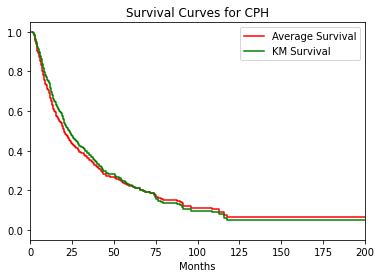

In [255]:
#for pred in preds_cox_func:
#    plt.step(t, pred, where="post", color="k")

plt.step(t,mean_surv, where="post", color="r", label="Average Survival")
plt.step(t_km, surv_km, where="post", color="g", label="KM Survival")
plt.legend(loc="best")
plt.title("Survival Curves for CPH")
plt.xlabel("Months")
plt.xlim(left=0,right=200)